## load package

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline
import keras
import numpy as np
import h5py
from __future__ import absolute_import
import cv2
import pandas as pd
from shapely.wkt import loads as wkt_loads
import tifffile as tiff
import os
import random
from keras.models import Model
from keras.layers import Input, merge, Convolution2D, MaxPooling2D, UpSampling2D, Reshape, core, Dropout,Cropping2D
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as K
from sklearn.metrics import jaccard_similarity_score, recall_score,roc_curve
from shapely.geometry import MultiPolygon, Polygon
import shapely.wkt
import shapely.affinity
from collections import defaultdict
from keras.layers.normalization import BatchNormalization

## set parameters

In [2]:
num_class = 10
DF = pd.read_csv('data/train_wkt_v4.csv')
GradSize = pd.read_csv('data/grid_sizes.csv', names=['ImageId', 'Xmax', 'Ymin'], skiprows=1)
Sample_Sub = pd.read_csv(os.path.join( 'data/sample_submission.csv'))
Image_size = 160
smooth = 1e-12
inDir = 'data'

## predict water(example)

(<matplotlib.figure.Figure at 0x20f655690>,
 <matplotlib.image.AxesImage at 0x2093ad890>)

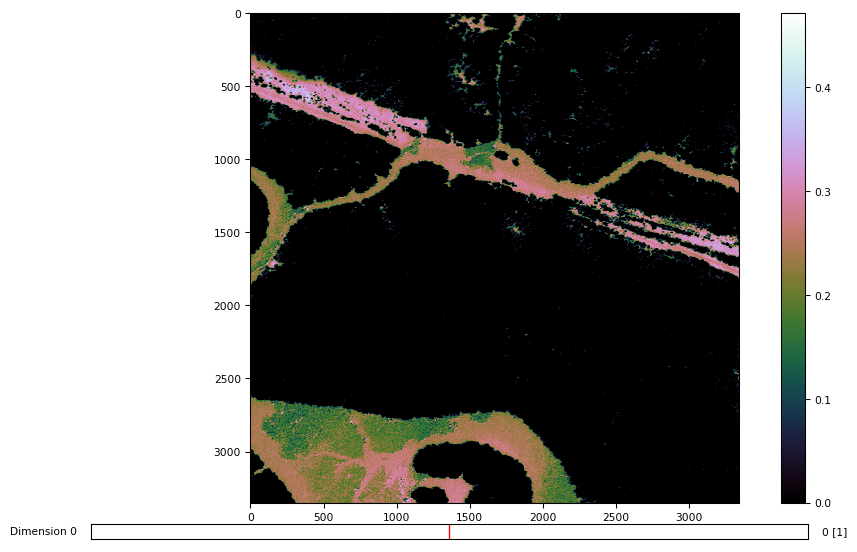

In [46]:
#predict the water
from skimage.transform import resize
img_filename_16bandM = 'data/three_band/6080_1_2.tif'
rgb = tiff.imread(img_filename_16bandM) 
rgb = np.rollaxis(rgb, 0, 3)
img_filename_16bandM = 'data/sixteen_band/6080_1_2_M.tif'
m = tiff.imread(img_filename_16bandM) 
RE = resize(m[5, :, :], (rgb.shape[0], rgb.shape[1]))
MIR = resize(m[7, :, :], (rgb.shape[0], rgb.shape[1]))
R = rgb[:, :, 2]
CCCI = (MIR - RE) / (MIR + RE) * (MIR - R) / (MIR + R)
tiff.imshow(CCCI)

## main functions

In [18]:
#In this dataset that we provide, we create a set of geo-coordinates that are in the range of x = [0,1] and y = [-1,0].
#These coordinates are transformed such that we obscure the location of where the satellite images are taken from. 
#The images are from the same region on Earth.
def coordinates2raster(coords, img_size, xymax):
    #For each image, you should be able to get the width (W) and height (H) from the image raster. For a 3-band image
    #that is 3391 x 3349 x 3, W is 3349, and H is 3391. Then you can scale your data as follows:
    Xmax, Ymax = xymax
    H, W = img_size
    W1 = 1.0 * W * W / (W + 1)
    H1 = 1.0 * H * H / (H + 1)
    xf = W1 / Xmax
    yf = H1 / Ymax
    coords[:, 1] *= yf
    coords[:, 0] *= xf
    coords_int = np.round(coords).astype(np.int32)
    return coords_int

def Get_XmaxXmin(grid_sizes_panda, imageId):
    # To utilize these images, we provide the grid coordinates of each image so you know how to scale them and align
    #them with the images in pixels. In grid_sizes.csv, you are given the Xmax and Ymin values for each imageId.
    xmax, ymin = grid_sizes_panda[grid_sizes_panda.ImageId == imageId].iloc[0, 1:].astype(float)
    return (xmax, ymin)


def Get_Poly_List(wkt_list_pandas, imageId, cType):
    # extract polygon list from file
    df_image = wkt_list_pandas[wkt_list_pandas.ImageId == imageId]
    multipoly_def = df_image[df_image.ClassType == cType].MultipolygonWKT
    polygonList = None
    if len(multipoly_def) > 0:
        assert len(multipoly_def) == 1
        polygonList = wkt_loads(multipoly_def.values[0])
    return polygonList

def Convert_Contour(polygonList, raster_img_size, xymax):
    # combined function: extract polygon list, then convert to raster, and get parameter list,interior list
    perim_list = []
    interior_list = []
    if polygonList is None:
        return None
    for k in range(len(polygonList)):
        poly = polygonList[k]
        perim = np.array(list(poly.exterior.coords))
        perim_c = coordinates2raster(perim, raster_img_size, xymax)
        perim_list.append(perim_c)
        for pi in poly.interiors:
            interior = np.array(list(pi.coords))
            interior_c = coordinates2raster(interior, raster_img_size, xymax)
            interior_list.append(interior_c)
    return perim_list, interior_list


def Plot_Mask(raster_img_size, contours, class_value=1):
    # plot the mask fill in the polygon, perim is 1, interior is 0, when given contours
    img_mask = np.zeros(raster_img_size, np.uint8)
    if contours is None:
        return img_mask
    perim_list, interior_list = contours
    cv2.fillPoly(img_mask, perim_list, class_value)
    cv2.fillPoly(img_mask, interior_list, 0)
    return img_mask


def generate_mask_for_image_and_class(raster_size, imageId, class_type, grid_sizes_panda=GradSize, wkt_list_pandas=DF):
    #generate mask for certain image and class
    xymax = Get_XmaxXmin(grid_sizes_panda, imageId)
    polygon_list = Get_Poly_List(wkt_list_pandas, imageId, class_type)
    contours = Convert_Contour(polygon_list, raster_size, xymax)
    mask = Plot_Mask(raster_size, contours, 1)
    return mask


def M(image_id):
    # read in certain image
    filename = os.path.join(inDir, 'sixteen_band', '{}_M.tif'.format(image_id))
    img = tiff.imread(filename)
    img = np.rollaxis(img, 0, 3)
    return img


def stretch_n(bands, lower_percent=0, higher_percent=100):
    #Contrast enhancement
    out = np.zeros_like(bands).astype(np.float32)
    n = bands.shape[2]
    for i in range(n):
        a = 0  # np.min(band)
        b = 1  # np.max(band)
        c = np.percentile(bands[:, :, i], lower_percent)
        d = np.percentile(bands[:, :, i], higher_percent)
        t = a + (bands[:, :, i] - c) * (b - a) / (d - c)
        t[t < a] = a
        t[t > b] = b
        out[:, :, i] = t
    
    return out.astype(np.float32)


def jaccard_coef(y_true, y_pred):
    # calculate jaccard coefficient
    intersection = K.sum(y_true * y_pred, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    
    return K.mean(jac)


def jaccard_coef_int(y_true, y_pred):
    # calculate jaccard coefficient when round every value to 0 and 1
    y_pred_pos = K.round(K.clip(y_pred, 0, 1))
    
    intersection = K.sum(y_true * y_pred_pos, axis=[0, -1, -2])
    sum_ = K.sum(y_true + y_pred, axis=[0, -1, -2])
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return K.mean(jac)



def stick_all_train():
    print "let's stick all imGradSize together"
    s = 835
    
    x = np.zeros((5 * s, 5 * s, 8))
    y = np.zeros((5 * s, 5 * s, num_class))
    
    ids = sorted(DF.ImageId.unique())
    print len(ids)
    for i in range(5):
        for j in range(5):
            id = ids[5 * i + j]
            
            img = M(id)
            img = stretch_n(img)
            print img.shape, id, np.amax(img), np.amin(img)
            x[s * i:s * i + s, s * j:s * j + s, :] = img[:s, :s, :]
            for z in range(num_class):
                y[s * i:s * i + s, s * j:s * j + s, z] = generate_mask_for_image_and_class(
                                                                                           (img.shape[0], img.shape[1]), id, z + 1)[:s, :s]
    print np.amax(y), np.amin(y)
    np.save('data/x_trn_%d' % num_class, x)
    np.save('data/y_trn_%d' % num_class, y)


def get_patches(img, msk, amt=1000, aug=True):
    is2 = int(1.0 * Image_size)
    xm, ym = img.shape[0] - is2, img.shape[1] - is2
    x, y = [], []
    tr = [0.4, 0.1, 0.1, 0.15, 0.3, 0.95, 0.1, 0.05, 0.001, 0.005]
    for i in range(amt):
        xc = random.randint(0, xm)
        yc = random.randint(0, ym)
        
        im = img[xc:xc + is2, yc:yc + is2]
        ms = msk[xc:xc + is2, yc:yc + is2]
        
        for j in range(num_class):
            sm = np.sum(ms[:, :, j])
            if 1.0 * sm / is2 ** 2 > tr[j]:
                if aug:
                    if random.uniform(0, 1) > 0.5:
                        im = im[::-1]
                        ms = ms[::-1]
                    if random.uniform(0, 1) > 0.5:
                        im = im[:, ::-1]
                        ms = ms[:, ::-1]
                x.append(im)
                y.append(ms)
    x, y = 2 * np.transpose(x, (0, 3, 1, 2)) - 1, np.transpose(y, (0, 3, 1, 2))
    print x.shape, y.shape, np.amax(x), np.amin(x), np.amax(y), np.amin(y)
    return x, y


def make_val():
    print "let's pick some samples for validation"
    img = np.load('data/x_trn_%d.npy' % num_class)
    msk = np.load('data/y_trn_%d.npy' % num_class)
    x, y = get_patches(img, msk, amt=1000)
    
    np.save('data/x_tmp_%d' % num_class, x)
    np.save('data/y_tmp_%d' % num_class, y)


def get_unet():
    inputs = Input((8, Image_size, Image_size))
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(inputs)
    conv1 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(pool1)
    conv2 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(pool2)
    conv3 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(pool3)
    conv4 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(pool4)
    conv5 = Convolution2D(512, 3, 3, activation='relu', border_mode='same')(conv5)

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(up6)
    conv6 = Convolution2D(256, 3, 3, activation='relu', border_mode='same')(conv6)

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(up7)
    conv7 = Convolution2D(128, 3, 3, activation='relu', border_mode='same')(conv7)

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(up8)
    conv8 = Convolution2D(64, 3, 3, activation='relu', border_mode='same')(conv8)

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(up9)
    conv9 = Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv9)

    conv10 = Convolution2D(num_class, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    model.compile(optimizer=Adam(), loss='binary_crossentropy', metrics=[jaccard_coef, jaccard_coef_int, 'accuracy'])
    return model

def get_unet2():
    inputs = Input((8, Image_size, Image_size))
    conv1 = BatchNormalization(mode=0, axis=1)(Convolution2D(32, 3, 3, activation='elu', border_mode='same')(inputs))
    conv1 = BatchNormalization(mode=0, axis=1)(Convolution2D(32, 3, 3, activation='relu', border_mode='same')(conv1))
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = BatchNormalization(mode=0, axis=1)(Convolution2D(64, 3, 3, activation='elu', border_mode='same')(pool1))
    conv2 = BatchNormalization(mode=0, axis=1)(Convolution2D(64, 3, 3, activation='elu', border_mode='same')(conv2))
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = BatchNormalization(mode=0, axis=1)(Convolution2D(128, 3, 3, activation='elu', border_mode='same')(pool2))
    conv3 = BatchNormalization(mode=0, axis=1)(Convolution2D(128, 3, 3, activation='elu', border_mode='same')(conv3))
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = BatchNormalization(mode=0, axis=1)(Convolution2D(256, 3, 3, activation='elu', border_mode='same')(pool3))
    conv4 = BatchNormalization(mode=0, axis=1)(Convolution2D(256, 3, 3, activation='elu', border_mode='same')(conv4))
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = BatchNormalization(mode=0, axis=1)(Convolution2D(512, 3, 3, activation='elu', border_mode='same')(pool4))
    conv5 = BatchNormalization(mode=0, axis=1)(Convolution2D(512, 3, 3, activation='elu', border_mode='same')(conv5))

    up6 = merge([UpSampling2D(size=(2, 2))(conv5), conv4], mode='concat', concat_axis=1)
    conv6 = BatchNormalization(mode=0, axis=1)(Convolution2D(256, 3, 3, activation='elu', border_mode='same')(up6))
    conv6 = BatchNormalization(mode=0, axis=1)(Convolution2D(256, 3, 3, activation='elu', border_mode='same')(conv6))

    up7 = merge([UpSampling2D(size=(2, 2))(conv6), conv3], mode='concat', concat_axis=1)
    conv7 = BatchNormalization(mode=0, axis=1)(Convolution2D(128, 3, 3, activation='elu', border_mode='same')(up7))
    conv7 = BatchNormalization(mode=0, axis=1)(Convolution2D(128, 3, 3, activation='elu', border_mode='same')(conv7))

    up8 = merge([UpSampling2D(size=(2, 2))(conv7), conv2], mode='concat', concat_axis=1)
    conv8 = BatchNormalization(mode=0, axis=1)(Convolution2D(64, 3, 3, activation='elu', border_mode='same')(up8))
    conv8 = BatchNormalization(mode=0, axis=1)(Convolution2D(64, 3, 3, activation='elu', border_mode='same')(conv8))

    up9 = merge([UpSampling2D(size=(2, 2))(conv8), conv1], mode='concat', concat_axis=1)
    conv9 = BatchNormalization(mode=0, axis=1)(Convolution2D(32, 3, 3, activation='elu', border_mode='same')(up9))
    conv9 = BatchNormalization(mode=0, axis=1)(Convolution2D(32, 3, 3, activation='elu', border_mode='same')(conv9))

    conv10 = Convolution2D(num_class, 1, 1, activation='sigmoid')(conv9)

    model = Model(input=inputs, output=conv10)
    return model

def calc_jacc(model):
    img = np.load('data/x_tmp_%d.npy' % num_class)
    msk = np.load('data/y_tmp_%d.npy' % num_class)
    
    prd = model.predict(img, batch_size=4)
    print prd.shape, msk.shape
    avg, trs = [], []
    
    for i in range(num_class):
        t_msk = msk[:, i, :, :]
        t_prd = prd[:, i, :, :]
        t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
        
        m, b_tr = 0, 0
        for j in range(10):
            tr = j / 10.0
            pred_binary_mask = t_prd > tr
            
            jk = jaccard_similarity_score(t_msk, pred_binary_mask)
            if jk > m:
                m = jk
                b_tr = tr
        print i, m, b_tr
        avg.append(m)
        trs.append(b_tr)
    
    score = sum(avg) / 10.0
    return score, trs


def Mask2Poly(polygons, im_size):
    img_mask = np.zeros(im_size, np.uint8)
    if not polygons:
        return img_mask
    int_coords = lambda x: np.array(x).round().astype(np.int32)
    exteriors = [int_coords(poly.exterior.coords) for poly in polygons]
    interiors = [int_coords(pi.coords) for poly in polygons
                 for pi in poly.interiors]
    cv2.fillPoly(img_mask, exteriors, 1)
    cv2.fillPoly(img_mask, interiors, 0)
    return img_mask


def mask2polygons(mask, epsilon=5, min_area=1.):
    # convert mask to polygons
    # first, find contours with cv2: it's much faster than shapely
    image, contours, hierarchy = cv2.findContours(
        ((mask == 1) * 255).astype(np.uint8),
        cv2.RETR_CCOMP, cv2.CHAIN_APPROX_TC89_KCOS)
    # create approximate contours to have reasonable submission size
    approx_contours = [cv2.approxPolyDP(cnt, epsilon, True)
                       for cnt in contours]
    if not contours:
        return MultiPolygon()
    # now messy stuff to associate parent and child contours
    cnt_children = defaultdict(list)
    child_contours = set()
    assert hierarchy.shape[0] == 1
    for idx, (_, _, _, parent_idx) in enumerate(hierarchy[0]):
        if parent_idx != -1:
            child_contours.add(idx)
            cnt_children[parent_idx].append(approx_contours[idx])
    # create actual polygons filtering by area (removes artifacts)
    all_polygons = []
    for idx, cnt in enumerate(approx_contours):
        if idx not in child_contours and cv2.contourArea(cnt) >= min_area:
            assert cnt.shape[1] == 1
            poly = Polygon(
                shell=cnt[:, 0, :],
                holes=[c[:, 0, :] for c in cnt_children.get(idx, [])
                       if cv2.contourArea(c) >= min_area])
            all_polygons.append(poly)
    # approximating polygons might have created invalid ones, fix them
    all_polygons = MultiPolygon(all_polygons)
    if not all_polygons.is_valid:
        all_polygons = all_polygons.buffer(0)
        # Sometimes buffer() converts a simple Multipolygon to just a Polygon,
        # need to keep it a Multi throughout
        if all_polygons.type == 'Polygon':
            all_polygons = MultiPolygon([all_polygons])
    return all_polygons


def get_scalers(im_size, x_max, y_min):
    h, w = im_size  
    h, w = float(h), float(w)
    w_ = 1.0 * w * (w / (w + 1))
    h_ = 1.0 * h * (h / (h + 1))
    return w_ / x_max, h_ / y_min


def train_net():
    print "start train net"
    x_val, y_val = np.load('data/x_tmp_%d.npy' % num_class), np.load('data/y_tmp_%d.npy' % num_class)
    img = np.load('data/x_trn_%d.npy' % num_class)
    msk = np.load('data/y_trn_%d.npy' % num_class)

    x_trn, y_trn = get_patches(img, msk)

    model = get_unet()
    model.load_weights('weights/unet.hdf5')
    model_checkpoint = ModelCheckpoint('weights/unet.hdf5', monitor='loss', save_best_only=True)
    for i in range(1):
        model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, verbose=1, shuffle=True,
                  callbacks=[model_checkpoint], validation_data=(x_val, y_val))
        del x_trn
        del y_trn
        x_trn, y_trn = get_patches(img, msk)
        score, trs = calc_jacc(model)
        print 'val jk', score
        model.save_weights('weights/unet_10_jk%.4f' % score)

    return model


def train_net2():
    def jaccard_coef_loss(y_true, y_pred):
        return -K.log(jaccard_coef(y_true, y_pred)) + binary_crossentropy(y_pred, y_true)
    def save_model(model):
        json_string = model.to_json()
        if not os.path.isdir('cache'):
            os.mkdir('cache')
        json_name = 'architecture_' + '.json'
        weight_name = 'model_weights_' + '.h5'
        open(os.path.join('cache', json_name), 'w').write(json_string)
        model.save_weights(os.path.join('cache', weight_name), overwrite=True)
    print "start train net"
    x_val, y_val = np.load('data/x_tmp_%d.npy' % num_class), np.load('data/y_tmp_%d.npy' % num_class)
    img = np.load('data/x_trn_%d.npy' % num_class)
    msk = np.load('data/y_trn_%d.npy' % num_class)

    x_trn, y_trn = get_patches(img, msk)
    model = get_unet2()
    from keras.backend import binary_crossentropy
    from keras.optimizers import Nadam
    from keras.callbacks import History
    history = History()
    callbacks = [
        history,
    ]
    model.compile(optimizer=Nadam(lr=1e-3), loss=jaccard_coef_loss, metrics=['binary_crossentropy', jaccard_coef_int])
    model.fit(x_trn, y_trn, batch_size=64, nb_epoch=50, verbose=1, shuffle=True,
              callbacks=callbacks, validation_data=(x_val, y_val))
    save_model(model)
    return model

def predict_id(id, model, trs):
    img = M(id)
    x = stretch_n(img)
    
    cnv = np.zeros((960, 960, 8)).astype(np.float32)
    prd = np.zeros((num_class, 960, 960)).astype(np.float32)
    cnv[:img.shape[0], :img.shape[1], :] = x
    
    for i in range(0, 6):
        line = []
        for j in range(0, 6):
            line.append(cnv[i * Image_size:(i + 1) * Image_size, j * Image_size:(j + 1) * Image_size])
        
        x = 2 * np.transpose(line, (0, 3, 1, 2)) - 1
        tmp = model.predict(x, batch_size=4)
        for j in range(tmp.shape[0]):
            prd[:, i * Image_size:(i + 1) * Image_size, j * Image_size:(j + 1) * Image_size] = tmp[j]

    for i in range(num_class):
        prd[i] = prd[i] > trs[i]

    return prd[:, :img.shape[0], :img.shape[1]]


def predict_test(model, trs):
    print "predict test"
    for i, id in enumerate(sorted(set(Sample_Sub['ImageId'].tolist()))):
        msk = predict_id(id, model, trs)
        np.save('msk/10_%s' % id, msk)
        if i % 100 == 0: print i, id


def make_submit():
    print "make submission file"
    df = pd.read_csv(os.path.join(inDir, 'sample_submission.csv'))
    print df.head()
    for idx, row in df.iterrows():
        id = row[0]
        kls = row[1] - 1

        msk = np.load('msk/10_%s.npy' % id)[kls]
        pred_polygons = mask2polygons(msk)
        x_max = GradSize.loc[GradSize['ImageId'] == id, 'Xmax'].as_matrix()[0]
        y_min = GradSize.loc[GradSize['ImageId'] == id, 'Ymin'].as_matrix()[0]

        x_scaler, y_scaler = get_scalers(msk.shape, x_max, y_min)

        scaled_pred_polygons = shapely.affinity.scale(pred_polygons, xfact=1.0 / x_scaler, yfact=1.0 / y_scaler,
                                                      origin=(0, 0, 0))

        df.iloc[idx, 2] = shapely.wkt.dumps(scaled_pred_polygons)
        if idx % 100 == 0: print idx
    print df.head()
    df.to_csv('subm/submission.csv', index=False)


def check_predict(id='6120_2_1'):
    model = get_unet()
    model.load_weights('weights/unet.hdf5')

    msk = predict_id(id, model, [0.4, 0.1, 0.4, 0.3, 0.3, 0.5, 0.3, 0.6, 0.1, 0.1])
    img = M(id)

    plt.figure(figsize=(10,10))
    ax1 = plt.subplot(131)
    ax1.set_title('image ID:6120_2_1')
    ax1.imshow(img[:, :, 5], cmap=plt.get_cmap('gist_ncar'))
    ax2 = plt.subplot(132)
    ax2.set_title('predict bldg pixels')
    ax2.imshow(msk[0], cmap=plt.get_cmap('gray'))
    ax3 = plt.subplot(133)
    ax3.set_title('predict bldg polygones')
    ax3.imshow(Mask2Poly(mask2polygons(msk[0], epsilon=1), img.shape[:2]), cmap=plt.get_cmap('gray'))

    plt.show()

## plot ROC

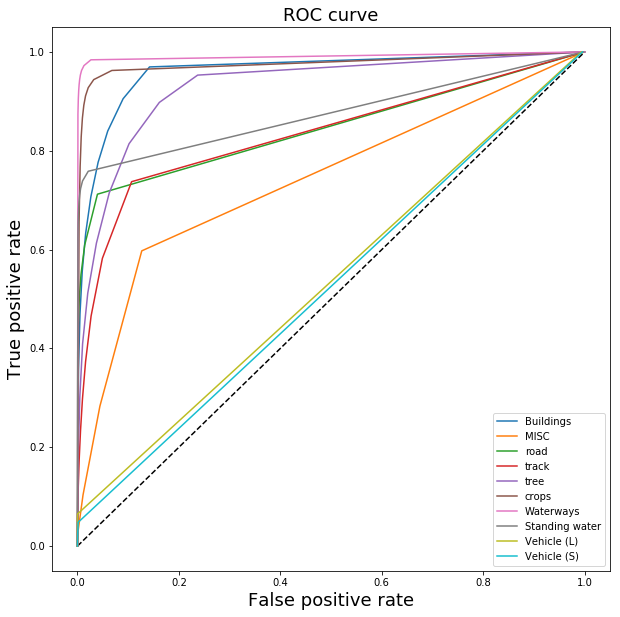

In [45]:
x_val, y_val = np.load('data/x_tmp_%d.npy' % num_class), np.load('data/y_tmp_%d.npy' % num_class)
img = np.load('data/x_trn_%d.npy' % num_class)
msk = np.load('data/y_trn_%d.npy' % num_class)

x_trn, y_trn = get_patches(img, msk)

model = get_unet()
model.load_weights('weights/unet.hdf5')
model_checkpoint = ModelCheckpoint('weights/unet.hdf5', monitor='loss', save_best_only=True)

model.fit(x_trn, y_trn, batch_size=64, nb_epoch=1, verbose=1, shuffle=True,
          callbacks=[model_checkpoint], validation_data=(x_val, y_val))
img = np.load('data/x_tmp_%d.npy' % num_class)
msk = np.load('data/y_tmp_%d.npy' % num_class)

prd = model.predict(img, batch_size=4)
print prd.shape, msk.shape
from sklearn.metrics import confusion_matrix
avg, trs = [], []
fpr_dict, tpr_dict = {},{}
for i in range(num_class):
    t_msk = msk[:, i, :, :]
    t_prd = prd[:, i, :, :]
    t_msk = t_msk.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
    t_prd = t_prd.reshape(msk.shape[0] * msk.shape[2], msk.shape[3])
    fpr_dict[i]=[];tpr_dict[i]=[]
    m, b_tr = 0, 0
    for j in range(10):
        tr = j / 10.0
        pred_binary_mask = t_prd > tr
        pred_binary_mask = pred_binary_mask*1
        #jk = jaccard_similarity_score(t_msk, pred_binary_mask)
        
        #print t_msk,pred_binary_mask
        tn, fp, fn, tp = confusion_matrix(t_msk.ravel(), pred_binary_mask.ravel()).ravel()
        fpr_dict[i].append(float(fp)/(fp + tn)) 
        tpr_dict[i].append(float(tp)/(tp + fn))
    print i
fig = plt.figure(figsize=(10,10))

plt.plot([0, 1], [0, 1], 'k--')
classs = ['Buildings','MISC','road','track','tree', 'crops','Waterways','Standing water','Vehicle (L)','Vehicle (S)']
for i in range(10):
    fpr_dict[i].append(0);tpr_dict[i].append(0)
    plt.plot(fpr_dict[i], tpr_dict[i], label=classs[i])
plt.xlabel('False positive rate',fontsize=18)
plt.ylabel('True positive rate',fontsize=18)
plt.title('ROC curve',fontsize=18)
plt.legend(loc='best')
plt.show()
fig.savefig('ROC.png')

## train，validation and submission

In [ ]:
#train the model, don't recommend to run on your local machine
train_net2()

In [13]:
#use trained weight to produce model, and provide submit file
stick_all_train()
make_val()
model = train_net()
score, trs = calc_jacc(model)
predict_test(model, trs)

Train on 3439 samples, validate on 1044 samples
Epoch 1/1 

3439/3439 [==============================] - 3823s - loss: 0.0459 - jaccard_coef: 0.4735 - jaccard_coef_int: 0.4819 - acc: 0.9829 - val_loss: 0.0356 - val_jaccard_coef: 0.5335 - val_jaccard_coef_int: 0.5415 - val_acc: 0.9859


/Users/weizhuoxiong/.virtualenvs/my_project/lib/python2.7/site-packages/ipykernel_launcher.py:193: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
/Users/weizhuoxiong/.virtualenvs/my_project/lib/python2.7/site-packages/ipykernel_launcher.py:194: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(32, (3, 3), padding="same", activation="relu")`
/Users/weizhuoxiong/.virtualenvs/my_project/lib/python2.7/site-packages/ipykernel_launcher.py:197: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
/Users/weizhuoxiong/.virtualenvs/my_project/lib/python2.7/site-packages/ipykernel_launcher.py:198: UserWarning: Update your `Conv2D` call to the Keras 2 API: `Conv2D(64, (3, 3), padding="same", activation="relu")`
/Users/weizhuoxiong/.virtualenvs/my_project/lib/python2.7/site-packages/ipykernel_launcher.py:201: UserWarning: Update your `Conv2D` call to the

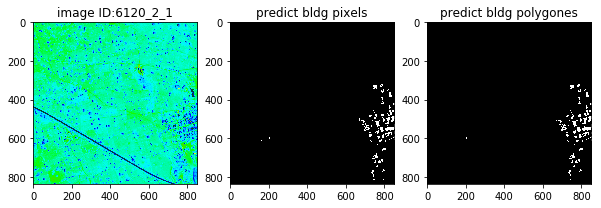

In [110]:
make_submit()
check_predict()